## 1. Imports

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os

In [76]:
# configuration pour une meilleure lisibilité
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# chargement du dataset
file_path = '../../data/top_50_71Countries_from_2023_to_2025.csv'
df = pd.read_csv(file_path)

print(f"Dimensions du dataset chargé : {df.shape}")
df.head()

Dimensions du dataset chargé : (10950, 25)


,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,duration_ms,album_name,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,7so0lgd0zP2Sbgs2d7a1SZ,Die With A Smile,"Lady Gaga, Bruno Mars",1,0,0,NaN,2025-04-12,89,False,251667,MAYHEM,2025-03-07,0.519,0.601,6,-7.727,0,0.0317,0.2890,0.000000,0.126,0.498,157.964,3
1,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,Billie Eilish,2,0,0,NaN,2025-04-12,99,False,210373,HIT ME HARD AND SOFT,2024-05-17,0.747,0.507,2,-10.171,1,0.0358,0.2000,0.060800,0.117,0.438,104.978,4
2,2RkZ5LkEzeHGRsmDqKwmaJ,Ordinary,Alex Warren,3,0,0,NaN,2025-04-12,85,False,186964,"You'll Be Alright, Kid (Chapter 1)",2024-09-26,0.368,0.694,2,-6.141,1,0.0600,0.7040,0.000007,0.055,0.391,168.115,3
3,4wJ5Qq0jBN4ajy7ouZIV1c,APT.,"ROSÉ, Bruno Mars",4,0,0,NaN,2025-04-12,92,False,169917,rosie,2024-12-06,0.777,0.783,0,-4.477,0,0.2600,0.0283,0.000000,0.355,0.939,149.027,4
4,2CGNAOSuO1MEFCbBRgUzjd,luther (with sza),"Kendrick Lamar, SZA",5,0,0,NaN,2025-04-12,94,False,177598,GNX,2024-11-21,0.707,0.575,2,-7.546,1,0.1250,0.2510,0.000000,0.248,0.576,138.008,4


## 2. Préparation des données (Gestion des doublons)
Pour le clustering, nous avons besoin d'une entrée unique par chanson.

In [77]:
# vérification des doublons sur l'identifiant unique
if df['spotify_id'].duplicated().any():
    print(f"Doublons présents : {df['spotify_id'].duplicated().sum()}. Réduction aux chansons uniques pour le clustering.")
    # on garde la première occurrence (les features audio sont constantes pour un même ID)
    df_songs = df.drop_duplicates(subset=['spotify_id']).copy()
else:
    print("Aucun doublon détecté. Le dataset contient déjà des chansons uniques.")
    df_songs = df.copy()

print(f"Nombre de chansons uniques à analyser : {df_songs.shape[0]}")

Doublons présents : 6141. Réduction aux chansons uniques pour le clustering.
Nombre de chansons uniques à analyser : 4809


## 3. Étude des distributions (Avant Normalisation)

       danceability       energy     loudness  speechiness  acousticness  \
count   4809.000000  4809.000000  4809.000000  4809.000000   4809.000000   
mean       0.673565     0.653472    -6.835983     0.104326      0.292049   
std        0.137892     0.166408     2.832175     0.099323      0.251179   
min        0.142000     0.003320   -46.113000     0.023000      0.000008   
25%        0.582000     0.549000    -8.188000     0.039800      0.075800   
50%        0.690000     0.668000    -6.457000     0.060600      0.224000   
75%        0.775000     0.775000    -5.021000     0.129000      0.464000   
max        0.975000     0.993000     2.194000     0.665000      0.994000   

       instrumentalness     liveness      valence        tempo  
count       4809.000000  4809.000000  4809.000000  4809.000000  
mean           0.016954     0.178809     0.548349   122.546125  
std            0.091007     0.135955     0.225496    28.045986  
min            0.000000     0.015400     0.000010    46

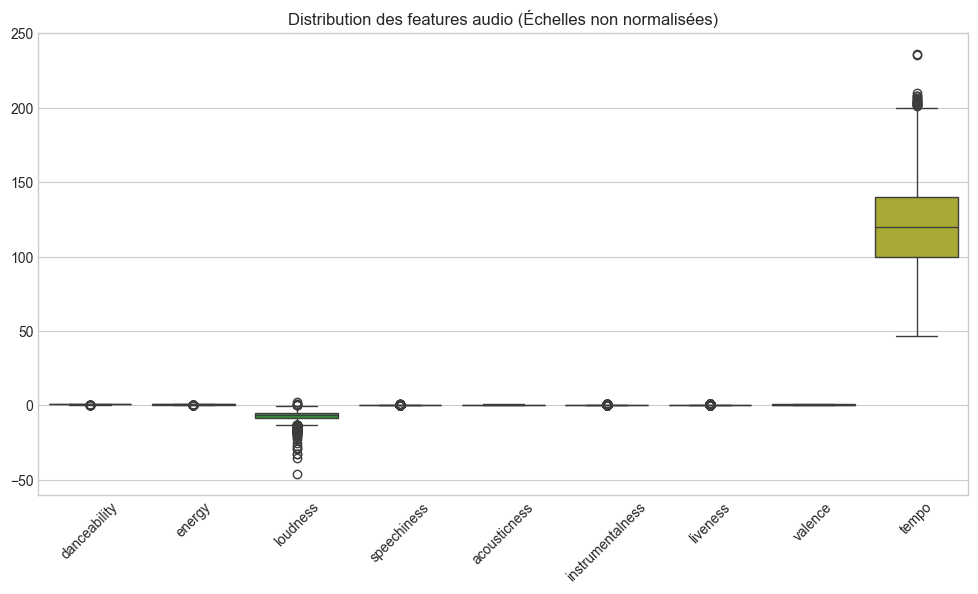

In [78]:
# Sélection des features pour le clustering
features = [
    'danceability', 'energy', 'loudness', 'speechiness', 
    'acousticness', 'instrumentalness', 'liveness', 
    'valence', 'tempo'
]

# Statistiques descriptives
print(df_songs[features].describe())

# Visualisation des distributions (Boxplots)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_songs[features])
plt.title("Distribution des features audio (Échelles non normalisées)")
plt.xticks(rotation=45)
plt.show()

## 4. Normalisation et Clustering (K-Means)

Inertie pour chaque k : [43281.00000000003, 35875.718815584376, 32007.42161126127, 29101.63936638006, 26385.742543766086, 24259.94811100053, 22713.428463424134, 21659.818309795723, 20874.25430434424, 20161.850646313174, 19562.861946893263, 19028.578672107065, 18570.800110389253, 18076.117363981808]


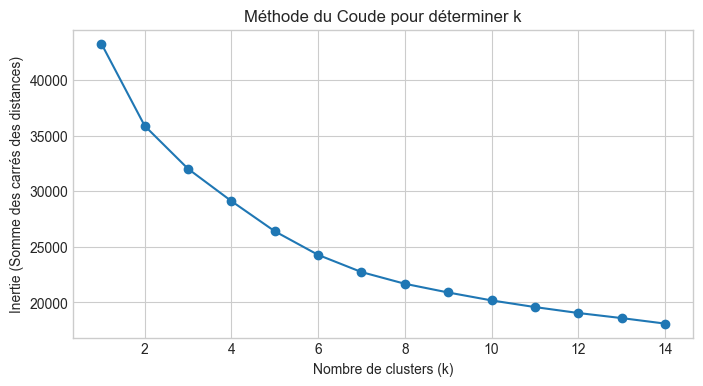

In [79]:
# normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_songs[features])

# recherche du nombre optimal de clusters
inertia = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

print("Inertie pour chaque k :", inertia)

# Visualisation du coude
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (Somme des carrés des distances)')
plt.title('Méthode du Coude pour déterminer k')
plt.show()

## 5. Application du Clustering et Analyse

Cluster Means:
                danceability    energy   loudness  speechiness  acousticness  \
cluster_label                                                                 
0                  0.585284  0.455713  -9.232423     0.057895      0.565666   
1                  0.758333  0.716674  -5.896804     0.076821      0.214434   
2                  0.719041  0.629034  -7.312714     0.309391      0.293934   
3                  0.635880  0.613514 -10.200130     0.082648      0.256027   
4                  0.595314  0.754325  -5.563434     0.079708      0.161759   

               instrumentalness  liveness   valence       tempo  
cluster_label                                                    
0                      0.006958  0.150925  0.386000  117.672356  
1                      0.005905  0.134584  0.670108  114.784121  
2                      0.003635  0.160565  0.539623  122.121650  
3                      0.611880  0.170860  0.411264  125.109413  
4                      0.003880  0

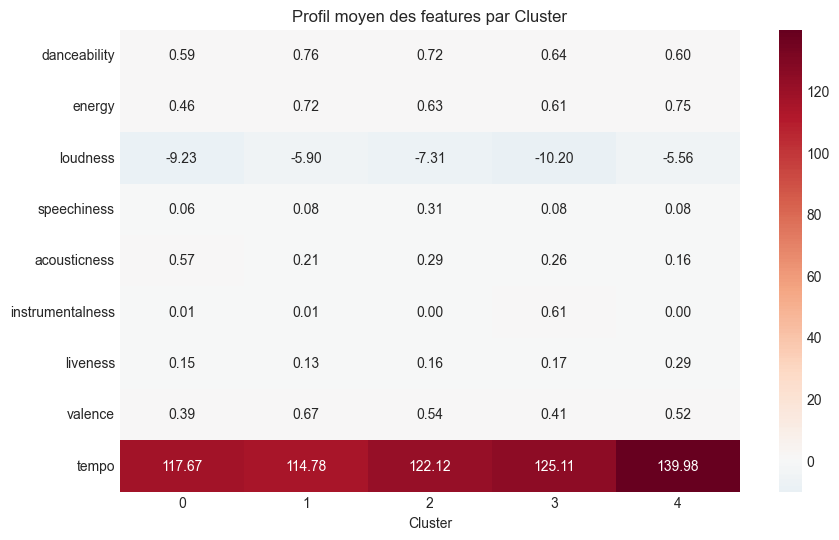

In [80]:
# k-means
k_optimal = 5
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df_songs['cluster_label'] = kmeans.fit_transform(X_scaled).argmin(axis=1) # ou kmeans.predict

# analyse des clusters : moyenne des features par cluster
cluster_means = df_songs.groupby('cluster_label')[features].mean()

print("Cluster Means:\n", cluster_means)

# Visualisation sous forme de Heatmap pour interpréter les "Genres"
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means.T, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Profil moyen des features par Cluster")
plt.xlabel("Cluster")
plt.show()

## Nommage des Clusters (Interprétation)

In [81]:
cluster_names = {
    0: "Mellow & Acoustic",      # Faible Energy, Forte Acousticness
    1: "Happy Pop / Dance",      # Forte Danceability, Forte Valence
    2: "Hip-Hop / Urban",        # Speechiness très élevée
    3: "Instrumental / Atmos",   # Instrumentalness élevée
    4: "High Energy / Fast"      # Tempo rapide (140 BPM) et Energy élevée
}

# Création de la nouvelle colonne explicite
df_songs['cluster_name'] = df_songs['cluster_label'].map(cluster_names)

# Vérification rapide : On regarde combien de chansons il y a par genre
print("Répartition des genres identifiés :")
print(df_songs['cluster_name'].value_counts())

Répartition des genres identifiés :
cluster_name
Happy Pop / Dance       1866
High Energy / Fast      1134
Mellow & Acoustic       1077
Hip-Hop / Urban          640
Instrumental / Atmos      92
Name: count, dtype: int64


## 6. Visualisation 2D (PCA) et Export

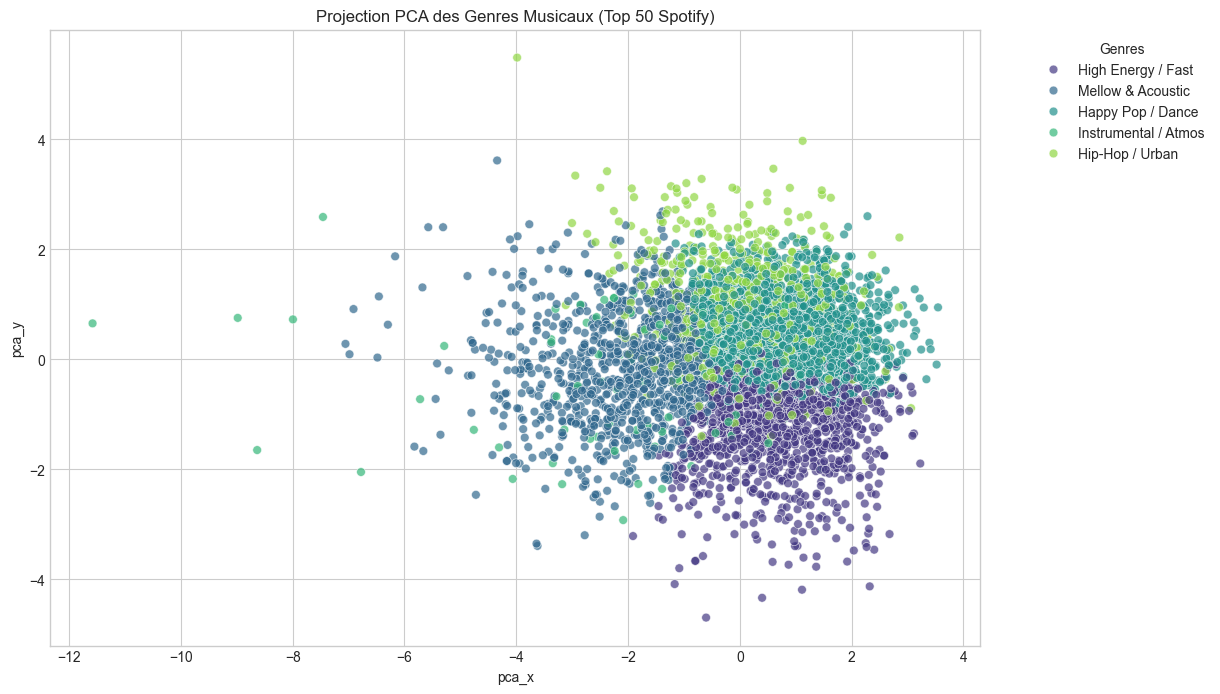

In [82]:
# réduction de dimension (PCA) pour la visualisation
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

df_songs['pca_x'] = coords[:, 0]
df_songs['pca_y'] = coords[:, 1]

# plot des clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_songs, 
    x='pca_x', 
    y='pca_y', 
    hue='cluster_name',
    palette='viridis',
    alpha=0.7,
    s=40
)

plt.title("Projection PCA des Genres Musicaux (Top 50 Spotify)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Genres")
plt.show()

## 7. Sauvegarde des résultats

In [83]:
output_path = '../../data/top_50_clustered.csv'
os.makedirs('../../data', exist_ok=True)
df_songs.to_csv(output_path, index=False)
print(f"Fichier sauvegardé avec succès : {output_path}")

Fichier sauvegardé avec succès : ../../data/top_50_clustered.csv
